# Coursework

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

In [2]:
data = yf.download("BA", start="2020-01-01", end="2020-10-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 144.39


In [4]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

In [5]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 92.83 %


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,328.549988,333.350006,327.700012,333.320007,331.348572,4544400
2020-01-03,330.630005,334.890015,330.299988,332.760010,330.791901,3875900
2020-01-06,329.299988,334.859985,327.880005,333.739990,331.766083,5355000
2020-01-07,334.260010,344.190002,330.709991,337.279999,335.285156,9898600
2020-01-08,332.399994,334.029999,329.600006,331.369995,329.410095,8239200


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-26,164.949997,165.500000,159.050003,160.830002,160.830002,16151100
2020-10-27,159.160004,160.250000,155.000000,155.240005,155.240005,15491900
2020-10-28,153.000000,153.949997,148.000000,148.139999,148.139999,20279800
2020-10-29,148.029999,150.100006,146.600006,148.289993,148.289993,14554300
2020-10-30,147.199997,149.169998,141.580002,144.389999,144.389999,15374700


### Stock Movement

In [8]:
data_price = pd.DataFrame(data['Adj Close'])

<AxesSubplot:xlabel='Date'>

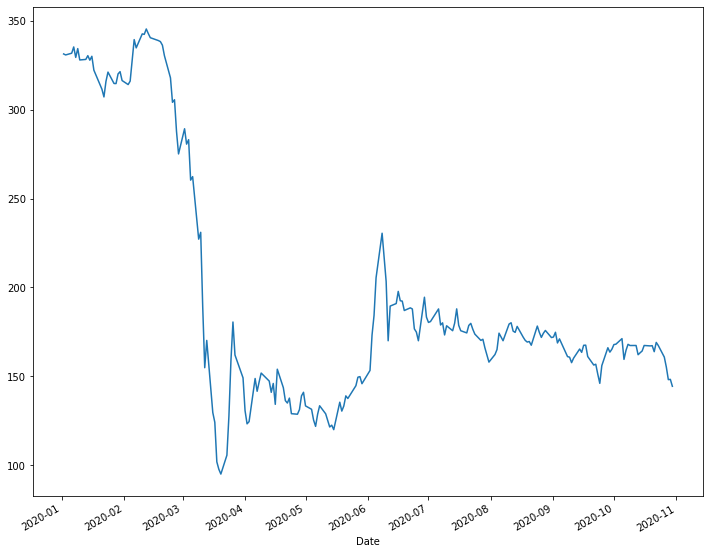

In [9]:
data_price['Adj Close'].plot(figsize=(12, 10))

### Calculate volatility by different rolling windows

In [10]:
data_price['1 week'] = log_return.rolling(5).std() * np.sqrt(252)
data_price['1 months'] = log_return.rolling(21).std() * np.sqrt(252)
data_price['3 months'] = log_return.rolling(63).std() * np.sqrt(252)
data_price['6 months'] = log_return.rolling(162).std() * np.sqrt(252)

<AxesSubplot:xlabel='Date'>

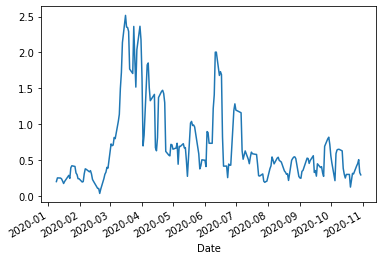

In [11]:
data_price['1 week'].plot()

<AxesSubplot:xlabel='Date'>

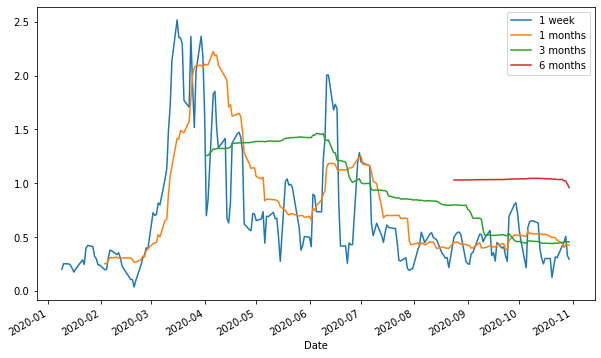

In [12]:
data_price[['1 week', '1 months', '3 months','6 months']].plot(figsize=(10, 6))

### Pricing an European put option

#### 1. Binomial Model

In [13]:
S0 = 144.39             # spot stock price
K = 150.0               # strike
T = 1/12                # maturity 
r = 0.01                # risk free rate 
sig = 0.93              # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [14]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [15]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [16]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.46221999817649967

In [17]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 26.34221252],
       [ 0.        ,  0.        ,  0.        , 59.30357216]])

In [18]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[19.77107336,  7.61412971,  0.        ,  0.        ],
       [ 0.        , 30.23013688, 14.16238056,  0.        ],
       [ 0.        ,  0.        , 44.05593311, 26.34221252],
       [ 0.        ,  0.        ,  0.        , 59.30357216]])

In [19]:
print('European ' + payoff, str( V[0,0]))

European put 19.771073359173986


#### 2. Monte Carlo Model

In [136]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [137]:
T = 1/12
r = 0.01
sigma = 0.93
S0 = 144.39
K = 150

In [138]:
S = mcs_simulation_np(500)

In [139]:
S = np.transpose(S)
S

array([[144.39      , 144.63494054, 145.42770254, ..., 193.50081179,
        191.93914124, 192.78670285],
       [144.39      , 145.5497557 , 147.6194982 , ..., 118.57489059,
        117.37884861, 117.44792076],
       [144.39      , 144.36074075, 144.54123863, ..., 164.21625244,
        162.95693135, 162.20293552],
       ...,
       [144.39      , 145.21009391, 144.6008986 , ..., 183.22776116,
        180.89682475, 175.4823596 ],
       [144.39      , 141.26697441, 141.98967885, ..., 137.44932127,
        140.11583027, 140.29320521],
       [144.39      , 145.5450339 , 143.60558111, ..., 169.60261134,
        168.81132013, 172.89080092]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

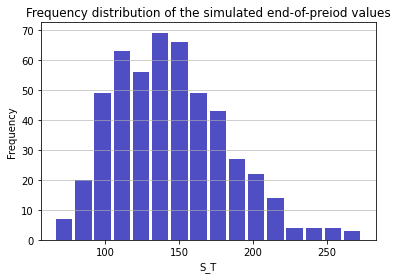

In [140]:
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [141]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 18.224891270807245


#### 3. Black-Scholes Model

##### Non-Dividend 

In [26]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [27]:
euro_option_bs(144.39, 150, 1/12, 0.01, 0.93, 'put')

18.604029545648828

In [28]:
S = np.linspace(100,200,11)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 150, 1, 0.01, 0.93, 'put')

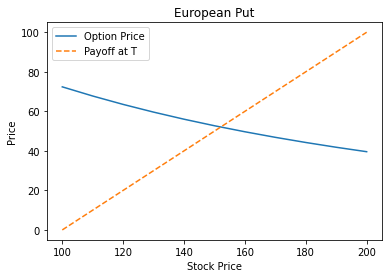

In [29]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-100,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

### Risk Analysis

##### Dividend function

In [30]:
def euro_option_bsm(S, K, T, r, q, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield (not applicable for BA so q=o)
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [31]:
euro_option_bsm(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')

13.118977476780074

In [32]:
euro_option_bsm(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

18.604029545648828

In [51]:
S = np.linspace(100,200,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 150, 1/12, 0.01, 0, 0.93, 'call')
    Put  [i] = euro_option_bsm(S[i], 150, 1/12, 0.01, 0, 0.93, 'put')

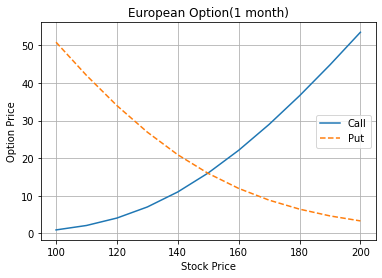

In [52]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option(1 month)')
plt.legend(['Call','Put'])

In [35]:
euro_option_bsm(144.39, 150, 3/12, 0.01, 0, 0.93, 'call')

24.487502081153202

In [36]:
euro_option_bsm(144.39, 150, 3/12, 0.01, 0, 0.93, 'put')

29.722970440772222

In [53]:
S = np.linspace(100,200,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 150, 3/12, 0.01, 0, 0.93, 'call')
    Put  [i] = euro_option_bsm(S[i], 150, 3/12, 0.01, 0, 0.93, 'put')

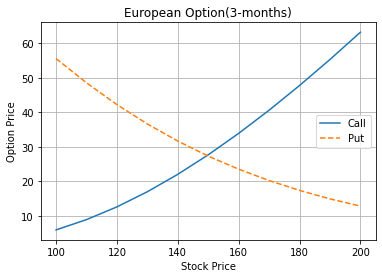

In [54]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option(3-months)')
plt.legend(['Call','Put'])

In [46]:
S = np.linspace(100,200,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 150, 6/12, 0.01, 0, 0.93, 'call')
    Put  [i] = euro_option_bsm(S[i], 150, 6/12, 0.01, 0, 0.93, 'put')

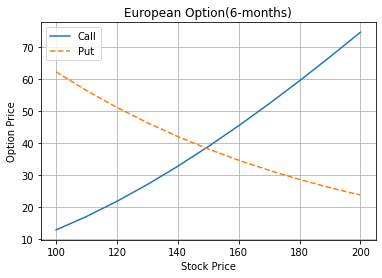

In [47]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option(6-months)')
plt.legend(['Call','Put'])

In [71]:
euro_option_bsm(144.39, 150, 1, 0.01, 0, 0.93, 'call')

50.402233421770354

In [73]:
euro_option_bsm(144.39, 150, 1, 0.01, 0, 0.93, 'put')

54.51970848414558

In [48]:
S = np.linspace(100,200,11)
Call = np.zeros((len(S),1))
Put = np.zeros((len(S),1))
for i in range(len(S)):
    Call [i] = euro_option_bsm(S[i], 150, 1, 0.01, 0, 0.93, 'call')
    Put  [i] = euro_option_bsm(S[i], 150, 1, 0.01, 0, 0.93, 'put')

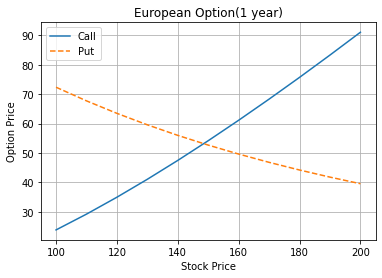

In [49]:
fig = plt.figure()
plt.plot(S, Call, '-')
plt.plot(S, Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Option(1 year)')
plt.legend(['Call','Put'])

In [60]:
euro_option_bsm(144.39, 160, 1/12, 0.01, 0, 0.93, 'call')

9.65268732453714

In [61]:
euro_option_bsm(144.39, 170, 1/12, 0.01, 0, 0.93, 'call')

6.999066177964458

In [62]:
euro_option_bsm(144.39, 180, 1/12, 0.01, 0, 0.93, 'call')

5.010713718714776

In [63]:
euro_option_bsm(144.39, 190, 1/12, 0.01, 0, 0.93, 'call')

3.5480625166879207

### Greeks

#### Delta

In [55]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [69]:
d=delta(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')
print('The value of Delta is', d.round(4),'.','If the stock price increase $1, then the value of the call option will increase $', d.round(4), '.')

The value of Delta is 0.4981 . If the stock price increase $1, then the value of the call option will increase $ 0.4981 .


In [112]:
d=delta(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')
print('The value of Delta is', d.round(4),'.','If the stock price increase $1, then the value of the put option will decrease $', -d.round(4), '.')

The value of Delta is -0.5019 . If the stock price increase $1, then the value of the put option will decrease $ 0.5019 .


In [58]:
S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

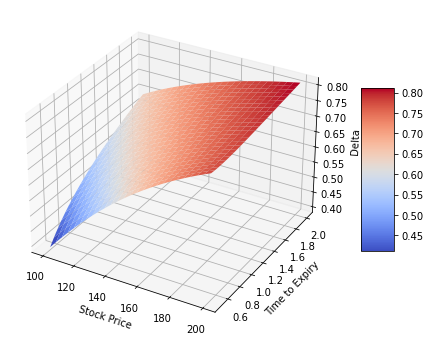

In [59]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Gamma

In [74]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [84]:
gamma(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')

0.03562088077340172

In [86]:
gamma(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

0.03562088077340172

In [76]:
S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

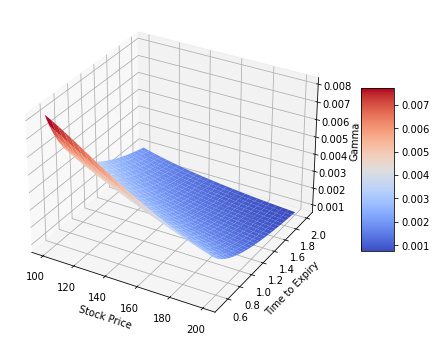

In [77]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Speed

In [80]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [85]:
speed(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')

7.004260479920784e-05

In [88]:
speed(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

7.004260479920784e-05

S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

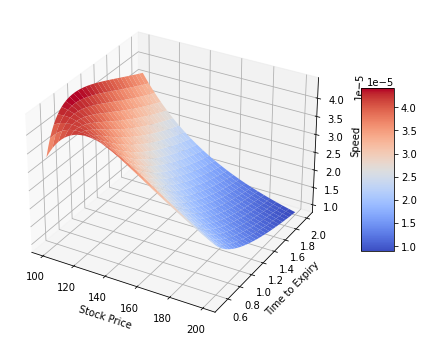

In [82]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Theta

In [142]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = - vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * T) + q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = - vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * T) + q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) - r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [143]:
theta(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')

-322.0109005651526

In [144]:
theta(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

-322.3334796238939

In [95]:
S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

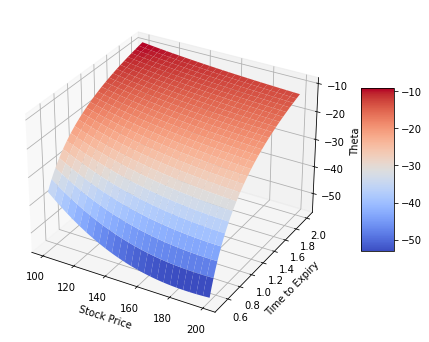

In [96]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Rho

In [97]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [98]:
rho(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')

4.900714424780775

In [99]:
rho(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

-7.588873247624955

In [105]:
S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

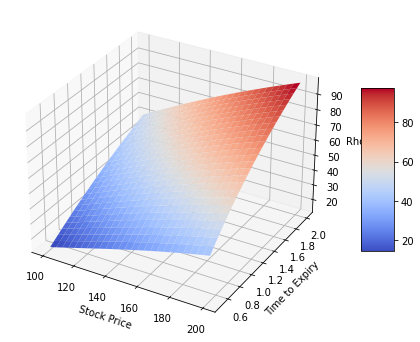

In [106]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

#### Vega

In [102]:
def vega(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [115]:
v = vega(144.39, 150, 1/12, 0.01, 0, 0.93, 'call')
print('The value of Vega is', v.round(4),'.','If the volatility increases 1%, then the value of the option will increase $', v.round(4)*0.01, '.')

The value of Vega is 16.6285 . If the volatility increases 1%, then the value of the option will increase $ 0.166285 .


In [104]:
vega(144.39, 150, 1/12, 0.01, 0, 0.93, 'put')

16.628454181738384

In [117]:
S = np.linspace(100, 200, 51)
T = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 150, T[i], 0.01, 0, 0.93, 'call')

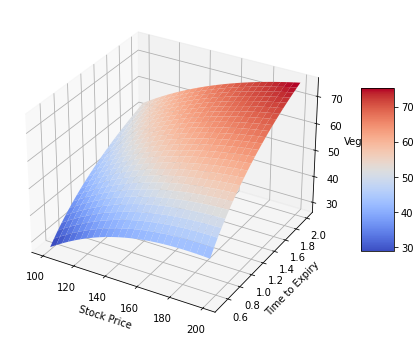

In [118]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [127]:
vol = np.linspace(0.5,1.5,15)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(144.39, 150, 1/12, 0.01, 0, vol[i], 'call')

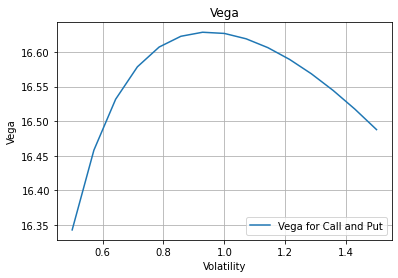

In [128]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])